In [1]:
# Jonathan Hoh
# Started 10/30/2020
# Python simulation of lock in digitization firmware

# Outline for algorithm
# Input: waveform (chopped) and digitized (how many bits?)
# First function will mix together a sampled signal with a square wave
## TODO: Add in white noise before the FFT and pink noise

In [2]:
#***********************************#
#                                   #
#             Packages              #        
#                                   #
#***********************************#


import dsp_py as dsp
import numpy as np
import colorednoise as cn
import matplotlib.pyplot as plt
from scipy import signal as sig 


In [8]:
#***********************************#
#                                   #
#             Constants             #        
#                                   #
#***********************************#


T_clk = 4*10**-9
adc_clk = 512 * 10 ** 6
fpga_clk = 250 * 10 ** 6
FFT_length = 1024
run_time = 0.03
source_freq = 0.5498 * 10 ** 12
lo_freq = 0.55 * 10 ** 12 
square_freq = 100 * 10 ** 3

# time should equal n * T_clk
# time array sets start a stop times along with resolution

#if_freq = the frequency of the mixed signal leaving the plasmonic mixer
if_freq = np.abs(lo_freq - source_freq)

In [9]:
#***********************************#
#                                   #
#            Functions              #        
#                                   #
#***********************************#


################################################
# Wave generation function:                    #
# Input: frequency and amount of time          #
# Output : I and Q arrays for wave             #
################################################

def cool_wave(amp, freq, time):
    omega = 2 * np.pi * freq    
    wave = amp * np.exp(1j * omega * time)
    i = np.real(wave)
    q = np.imag(wave)
    return i,q
    

#########################################################
#    Complex multipler function:                        #
#    Input: I_1, Q_1, I_2, Q_2                          #
#    Output: Mixed wave in quadrature (I_mix, Q_mix)    #
#########################################################

def c_mult (I_1, Q_1, I_2, Q_2): 
    I_mix = I_1 * I_2 - Q_1 * Q_2 
    Q_mix = I_1 * Q_2 + Q_1 * I_2 
    return I_mix, Q_mix
    
################################################################################
# the last numerical input here will represent the bit resolution of the wave  #
# t = np.linspace(0, 1, 500, endpoint=False)                                   #
# sqare_wave = sig.square(2 * np.pi * freq * t)                                #
# here we get the frequency of the square wave we're creating                  # 
#plt.plot(t, sig.square(2 * np.pi * freq * t))                                 #
#plt.ylim(-2, 2)                                                               #
#plt.show()                                                                    #
################################################################################


In [10]:
#***********************************#
#                                   #
#     Main Script Starts Here       #        
#                                   #
#***********************************#


###########################
#     Make FFT Frames     #
###########################

    ##### for a 1024 pt FFT, one FFT frame will take 1024/adc_clk (seconds) ##### 

# frame time = Time for 1 FFT to populate

frame_time = FFT_length / (adc_clk)

    ##### The number of fft frames to be created equals the                        #
    #     run time of the test over the amount of time it takes to FFT a frame #####

# ratio = number of FFT frames created over run time

ratio = int(run_time/frame_time)
frame_times = np.zeros(ratio)

    ##### Create an array with the times of the FFT frames #####

for i in range (ratio):                                 
    
    frame_times[i] = i * frame_time
    
# Now create array which contains frequency span of FFT
n = 1024
# print(i_mix.size)
timestep = 1/adc_clk
# note this value comes from the linspace used for the time array. length/number of samples
fft_freq = np.fft.fftfreq(n, d=timestep)

In [11]:
    ##### Here we create an array which will hold the frequency range found in our FFT (for plotting and indexing) #####

n = 1024
timestep = 1/adc_clk

# fft_freq = the frequencies that relate to the center of the FFT bins
fft_freq = np.fft.fftfreq(n, d=timestep)

In [12]:
    ##### Create an array of times that will be used to create the "pieces" of the wave #####

times_1 = np.zeros((ratio-1, FFT_length))

    ##### Populate time array with lengths to be used later #####

for i in range(ratio-1):
    
     times_1[i] = np.linspace(frame_times[i], frame_times[i+1], FFT_length)
    
    ##### Make an array to store FFT frames #####

fft_frames = np.zeros((ratio, FFT_length), dtype = complex)

    ##### Now populate the FFT frames each with 1024 points of data #####

# set wave frequency to 0.55 THz
sig_i, sig_q = cool_wave(2, if_freq, times_1)
print(np.shape(sig_i))

(14999, 1024)


In [7]:
    ##### Now add some white noise #####
w_noise1 = np.random.normal(0, .1, sig_i.shape)     # white noise for observed signal
w_noise2 = np.random.normal(0, .05, sig_i.shape)    # white noise for square wave (needs less)

    ##### And some pink noise #####
beta = 1                                            # the exponent for pink noise
samples = sig_i.shape                               # number of samples to generate (mimic the dimensions of the signal)
y = cn.powerlaw_psd_gaussian(beta, samples)

    ##### Add the noise to the IQ signals for our realistic example #####
    
noisy_sig_i = sig_i + w_noise1 + y
noisy_sig_q = sig_q + w_noise1 + y


In [8]:
    ##### Now make the square wave #####

# Since sig.square goes from -1 to 1, we have to tweak it to be 0 to 1 in order to mimic a chopper 
    
sq_wave_i = 0.5 * (sig.square(2 * np.pi * square_freq * times_1) + 1) 
sq_wave_q = 0.5 * (sig.square(2 * np.pi * square_freq * times_1 + (np.pi/4)) + 1) 

    ##### Add a lil bit of white noise to the square waves just for kicks #####

noisy_sq_i = sq_wave_i
noisy_sq_q = sq_wave_q

In [9]:
    ##### Now mix together square chop and signal wave #####

i_mix_noise, q_mix_noise = c_mult(noisy_sig_i, noisy_sig_q, noisy_sq_i, noisy_sq_q)

In [10]:
    ##### Take FFT of spectrum #####
    
noisy_spec = np.fft.fft(i_mix_noise + 1j*(q_mix_noise), n = FFT_length)

fft_frames = (noisy_spec)
    
    ##### Turn this FFT into the power spectrum we will be tracking #####

mags = np.sqrt(np.real(fft_frames)**2 + np.imag(fft_frames)**2)
#print(np.shape(fft_frames))

In [11]:
####TESTING BLOCK####

#max_bin = []
#for i in range(int(ratio/2)):
#    peak = np.where(mags[i] == mags[i].max())
#    max_bin.append(peak)
#print(max_bin)

# It seems bin 82 is where we will find our peak for 200 MHz IF

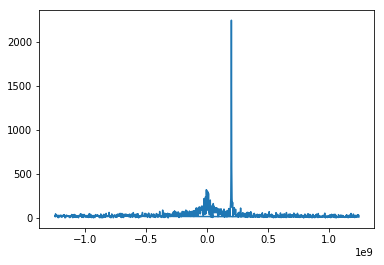

In [12]:
####TESTING BLOCK####

plt.plot(fft_freq, mags[82])
#print(np.shape(mags))
#print(np.shape(mags[2000]))

In [13]:
########################################
#    Extracting Channel Time Stream    #
########################################  

    ##### Create an array of zeros to hold time stream info #####
  
t_streams = np.zeros((FFT_length, ratio-1), dtype=complex)
print(np.shape(t_streams))

    ##### Slice and dice array to convert frames into time streams #####
t_mags = np.transpose(mags)
t_streams = t_mags


(1024, 73241)


In [14]:
#########################################
#    Mixing Channel Timestreams Down    #
#########################################      

    ##### Create time array to control internally generated wave #####

times_2 = np.linspace(0, run_time, ratio-1)

    ##### Create generated signal inside FPGA at square wave frequency #####
    
gen_i, gen_q = cool_wave(1, square_freq, times_2)


In [15]:
##### Create array to store dc streams of mixed data #####

dc_streams = []

    ##### Now mix each channel timestream with a generated wave at square frequency #####
    
for i in range(len(t_streams)-1):
    downmix = (t_streams[i])* gen_i
    dc_streams.append(downmix)


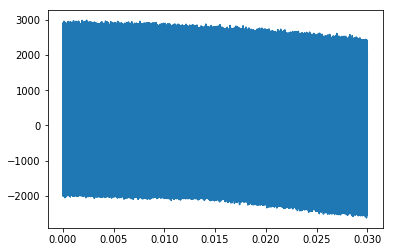

In [16]:
##################################
#     For plotting at the end    #
##################################
# Now create array which contains frequency span of FFT
n = 1024
# print(i_mix.size)
#timestep = 1/adc_clk
# note this value comes from the linspace used for the time array. length/number of samples
#fft_freq = np.fft.fftfreq(n, d=timestep)

#plt.plot(fft_freq, (spec.real**2 + spec.imag**2))
#plt.plot(fft_freq, (fft_frames[25]**2 + fft_frames[25]**2))
#plt.xlim(0, 200)

plt.plot(times_2, dc_streams[82])

plt.show()

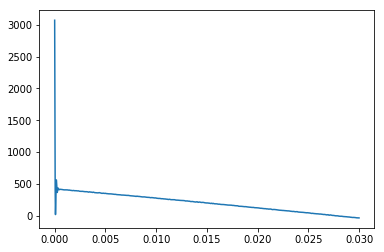

In [17]:
##### MAKING A CHEEKY INTEGRATOR #####

N  = 5    # Filter order
Wn = 0.005 # Cutoff frequency
B, A = sig.butter(N, Wn, output='ba')
dc_fil = sig.filtfilt(B,A,dc_streams[82])
plt.plot(times_2, dc_fil)

(0, 200000)

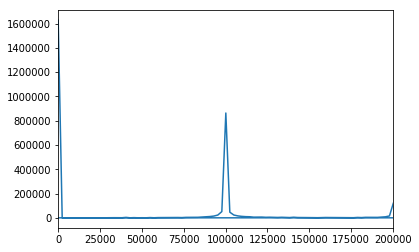

In [18]:
downmix = np.fft.fft(np.real(t_streams[82]) + 1j*(np.imag(t_streams[82])), n = FFT_length)
final = np.sqrt(np.real(downmix)**2 + np.imag(downmix)**2)

# Now create array which contains frequency span of FFT
n = 1024
# print(i_mix.size)
timestep = 1024/adc_clk
# note this value comes from the linspace used for the time array. length/number of samples
fft_freq = np.fft.fftfreq(n, d=timestep)
plt.plot(fft_freq, final)
plt.xlim(0, 200 * 10 **3)


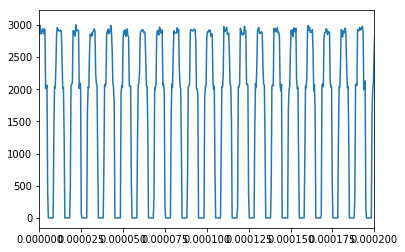

In [19]:
plt.plot(times_2, t_streams[82])
plt.xlim(0, .0002)
plt.show()